In [1]:
%load_ext autoreload
%autoreload 2

# IMPORT LIBRARIES
from Dataset import *
import cupy as cp
from bpnn_cuda import BPNN
from tqdm.notebook import tqdm

def convert_categories(y_cat):
    desired = cp.array([0 if y[0] == 1 else 1 for y in y_cat])
    return desired

def get_data():
    d = Dataset.load_gzip(os.path.join("datasets", "face_mask_pickled"), "dataset_gray_conv_test_2.pkl.gzip")

    ndimen = d.train.X.shape[1]

    # Structure Training Data for BPNN
    training_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.train.X]
    training_results = [cp.asarray(y.reshape(-1, 1)) for y in d.train.y]

    training_data = zip(training_inputs, training_results)
    # Structure Validation Data for BPNN
    validation_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.validation.X]
    validation_data = zip(validation_inputs, convert_categories(d.validation.y))
    # Structure Testing Data for BPNN
    testing_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.test.X]
    testing_data = zip(testing_inputs, convert_categories(d.test.y))

    return training_data, validation_data, testing_data, ndimen


training_data, validation_data, testing_data, ndimen = get_data()
print(f"Input Dimension: {ndimen}")

ntrials = 5
max_epochs = 30
init_nc = [ndimen, 200, 2]
init_b = 50
init_lr = 0.55

Input Dimension: 900


In [ ]:
model_BPNN = BPNN(init_nc, verbose=True, random_init=True)
final_score, eval_scores, eval_scores_deltas, conv_time = model_BPNN.train(training_data,
                                                                           max_epochs=max_epochs,
                                                                           batch_size=init_b,
                                                                           learning_rate=init_lr,
                                                                           evaluation_data=validation_data)


Training Epoch vs. Accuracy (Effect of Network Configuration)


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

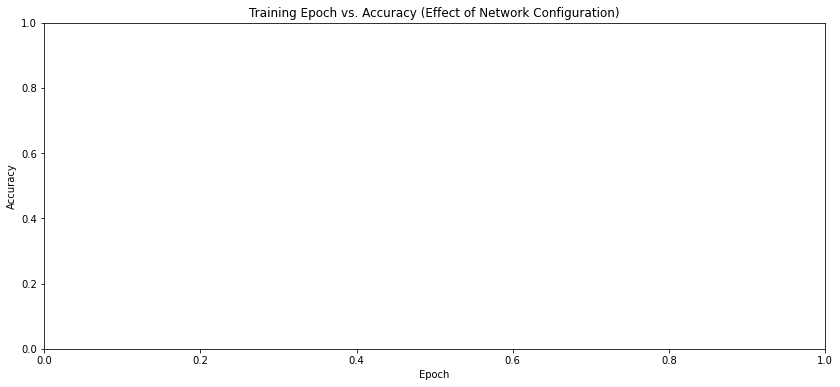

In [2]:
def plot_accuracies_hidden_layers_and_nodes(save_dir, layers_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Network Configuration)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(
        f"Training Epoch vs. Accuracy (Effect of Network Configuration)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for layers in tqdm(layers_arr):
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(layers, verbose=False, random_init=True)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=init_b,
                                                                               learning_rate=init_lr,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)
            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{layers} => {final_score_avg} ({conv_time})')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = layers
        plt.plot(epoch_scores, label=f'{layers} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_layers_vs_acc', dpi=100)

    return best_config


layers_arr = [[ndimen, 200, 50, 2],
              [ndimen, 200, 100, 2],
              [ndimen, 200, 200, 2],
              [ndimen, 200, 300, 50, 2],
              [ndimen, 200, 350, 100, 2],
              [ndimen, 200, 400, 150, 2],
              [ndimen, 200, 450, 200, 2],

              [ndimen, 300, 50, 2],
              [ndimen, 300, 100, 2],
              [ndimen, 300, 200, 2],
              [ndimen, 300, 300, 2],
              [ndimen, 300, 300, 50, 2],
              [ndimen, 300, 350, 100, 2],
              [ndimen, 300, 400, 150, 2],
              [ndimen, 300, 450, 150, 2],

              [ndimen, 400, 50, 2],
              [ndimen, 400, 100, 2],
              [ndimen, 400, 200, 2],
              [ndimen, 400, 300, 2],
              [ndimen, 400, 400, 2],
              [ndimen, 400, 300, 50, 2],
              [ndimen, 400, 350, 100, 2],
              [ndimen, 400, 400, 150, 2],
              [ndimen, 400, 450, 150, 2],

              [ndimen, 500, 50, 2],
              [ndimen, 500, 100, 2],
              [ndimen, 500, 200, 2],
              [ndimen, 500, 300, 2],
              [ndimen, 500, 400, 2],
              [ndimen, 500, 400, 2],
              [ndimen, 500, 500, 2],
              [ndimen, 500, 300, 50, 2],
              [ndimen, 500, 350, 100, 2],
              [ndimen, 500, 400, 150, 2],
              [ndimen, 500, 450, 150, 2]]




best_nc = plot_accuracies_hidden_layers_and_nodes("img", layers_arr)
print(f"Best network configuration: {best_nc}")


In [ ]:
def plot_accuracies_mini_batch_size(save_dir, batch_size_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Batch Size)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(f"Training Epoch vs. Accuracy (Effect of Batch Size)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for batch_size in batch_size_arr:
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in tqdm(range(ntrials)):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(best_nc, verbose=False, random_init=True)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=batch_size,
                                                                               learning_rate=init_lr,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)
            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{batch_size} => {final_score_avg} ({conv_time})')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = batch_size
        plt.plot(epoch_scores, label=f'{batch_size} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_batch_vs_acc', dpi=100)

    return best_config


batch_size_arr = [20, 25, 30, 35, 40, 45, 50]

best_b = plot_accuracies_mini_batch_size("img", batch_size_arr)
print(f"Best batch size: {best_b}")

In [ ]:
def plot_accuracies_learning_rate(save_dir, learning_rate_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")
    print(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for learning_rate in learning_rate_arr:
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in tqdm(range(ntrials)):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(best_nc, verbose=False, random_init=True)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=best_b,
                                                                               learning_rate=learning_rate,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)

            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{learning_rate} => {final_score_avg} ({conv_time})')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = learning_rate

        plt.plot(epoch_scores, label=f'{learning_rate} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_lr_vs_acc', dpi=100)

    return best_config


learning_rate_arr = [0.75, 0.65, 0.60, 0.55, 0.5, 0.45, 0.40, 0.35, 0.25]
best_lr = plot_accuracies_learning_rate("img", learning_rate_arr)
print(f"Best learning rate: {best_lr}")

In [ ]:
"""
Plot the convergence curve of BPNN
"""

training_data, validation_data, testing_data, ndimen = get_data()

nn = BPNN(best_nc, verbose=True, random_init=True)
final_score, eval_scores, eval_scores_deltas, nn_conv_time = nn.train(training_data,
                                                                      max_epochs=max_epochs,
                                                                      batch_size=best_b,
                                                                      learning_rate=best_lr,
                                                                      evaluation_data=validation_data,
                                                                      evaluation_treshold=None)

fig = plt.figure(figsize=(14, 6))

plt.title(f"Training Epoch vs. Accuracy with (Final Model)")
plt.xlabel("Epoch")
plt.ylabel('Accuracy')

plt.plot(eval_scores, label='Convergence Curve')

plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_best_model', dpi=100)


In [ ]:

import gzip

# make directory to save generated images to
os.makedirs('models', exist_ok=True)


def save_best_model():
    # Save the best BPNN model to a pickle file
    with gzip.open('models/bpnn_best_model.pkl.gzip', 'wb') as f:
        pickle.dump(nn, f)


def save_testing_pred(data):
    # Tuples (X, y, y_pred)

    new_data = []
    for (x, y) in data:
        decision = np.argmax(nn.feedforward(x))
        new_data.append((x, y, decision))

    with gzip.open('models/bpnn_testing_pred.pkl.gzip', 'wb') as f:
        pickle.dump(new_data, f)


training_data, validation_data, testing_data, ndimen = get_data()
save_best_model()
save_testing_pred(testing_data)


In [ ]:
def evaluate(dataset, name):

    acc = 0
    acc0 = 0
    len0 = 0
    acc1 = 0
    len1 = 0

    for (x, y) in dataset:
        decision = np.argmax(nn.feedforward(x))

        if decision == y:
            acc += 1
        if y == 0:
            len0 += 1
            if decision == y:
                acc0 += 1
        if y == 1:
            len1 += 1
            if decision == y:
                acc1 += 1

    nn_acc = acc / (len0 + len1)
    # Compute class accuracies
    nn_acc0 = acc0 / len0
    nn_acc1 = acc1 / len1

    print(f'Overall {name} Accuracy: {nn_acc}')
    print(f'Class 0 {name} Accuracy: {nn_acc0}')
    print(f'Class 1 {name} Accuracy: {nn_acc1}')

    return nn_acc, nn_acc0, nn_acc1


training_data, validation_data, testing_data, ndimen = get_data()


vnn_acc, vnn_acc0, vnn_acc1 = evaluate(validation_data, "Validation")
print()
tnn_acc, tnn_acc0, tnn_acc1 = evaluate(testing_data, "Testing")


In [ ]:
# Plot a barchart comparing the validation vs testing accuracies overall, for class 0, and for class 1 side by side

# set the y axis major ticks to .1 and minor ticks to .01
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.01)


fig = plt.figure(figsize=(14, 10))

plt.title(f"Validation vs. Testing Accuracy")
plt.xlabel("Accuracy")

width = 0.25
plt.barh(0 + width/2, tnn_acc, width, label='Testing', color='green')
plt.barh(0 - width/2, vnn_acc, width, label='Validation', color='blue')

plt.barh(1 + width/2, tnn_acc0, width, color='green')
plt.barh(1 - width/2, vnn_acc0, width, color='blue')

plt.barh(2 + width/2, tnn_acc1, width, color='green')
plt.barh(2 - width/2, vnn_acc1, width, color='blue')

plt.yticks(np.arange(0, 3, 1), ['Overall', 'Class 0', 'Class 1'])
plt.xticks(major_ticks)
plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_validation_vs_testing', dpi=100)
